In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import tensorflow as tf
import random
import os

In [2]:
seed = 25
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
df = pd.read_csv("./Data/adult_cleaned.csv")
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
# Drop missing rows
df.dropna(inplace=True)

# Split X/y
X = df.drop('income', axis=1)
y = df['income']

# Label encode target
le = LabelEncoder()
y = le.fit_transform(y)

# Categorical & numerical features
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(include='number').columns.tolist()

# ColumnTransformer: One-hot categorical + scale numeric
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features),
    ('num', StandardScaler(), num_features)
])

# Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit-transform
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)


In [5]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/Users/rohandas/Documents/GitHub/ML_Project/tfenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
cw_dict = dict(enumerate(cw))

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    class_weight=cw_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7115 - loss: 0.5027 - val_accuracy: 0.8104 - val_loss: 0.3782
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.8062 - loss: 0.3851 - val_accuracy: 0.8157 - val_loss: 0.3658
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.8106 - loss: 0.3764 - val_accuracy: 0.8211 - val_loss: 0.3630
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.8148 - loss: 0.3701 - val_accuracy: 0.8173 - val_loss: 0.3682
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.8159 - loss: 0.3648 - val_accuracy: 0.8253 - val_loss: 0.3605
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8207 - loss: 0.3643 - val_accuracy: 0.8196 - val_loss: 0.3651
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.8193 - loss: 0.3624 - val_accuracy: 0.8192 - val_loss: 0.3682
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.8184 - loss: 0.3583 - val_

In [8]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.8200 - loss: 0.3530

Test Accuracy: 0.8240


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


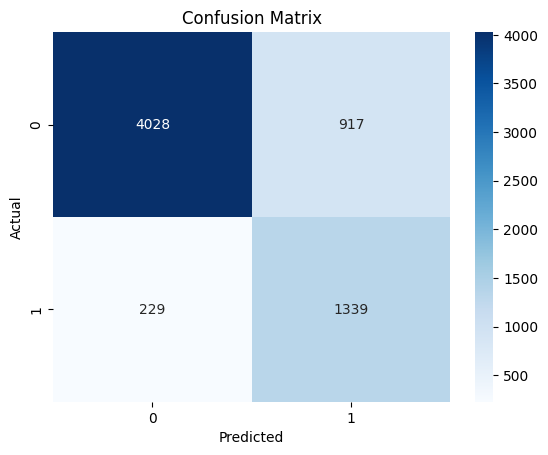

              precision    recall  f1-score   support

           0       0.95      0.81      0.88      4945
           1       0.59      0.85      0.70      1568

    accuracy                           0.82      6513
   macro avg       0.77      0.83      0.79      6513
weighted avg       0.86      0.82      0.83      6513



In [9]:
# Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred))